In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annecw","key":"036426bc4a1e20caf1c75bdb57d6e99d"}'}

In [ ]:
# Kaggle konfiguration
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 1. Kaggle Download & Unzip (automatisch)
import os

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# Kaggle API: Dataset herunterladen
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# Hauptzip entpacken
if not os.path.exists(DATA_DIR):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# Train, Test, SampleSubmission entpacken
!unzip -oq datasciencebowl/train.zip -d datasciencebowl/train
!unzip -oq datasciencebowl/test.zip -d datasciencebowl/test
!unzip -oq datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# Doppelten train-Ordner zusammenführen (rsync)
if os.path.exists("datasciencebowl/train/train"):
    !rsync -a --ignore-existing datasciencebowl/train/train/ datasciencebowl/train/
    !rm -r datasciencebowl/train/train

print("Done!")

✅ Download und Entpackung abgeschlossen!


In [ ]:
# 2. Imports
import copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
# 3. Custom dataset
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None):
        self.samples = []
        if classes is None:
            classes = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
        self.label2idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((cls, os.path.join(cls_path, f)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, path = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]

In [ ]:
# 4. Filter Classes by Threshold
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df_counts = df_counts.sort_values("num_images", ascending=False)

threshold = 114
classes_filtered = df_counts[df_counts["num_images"] > threshold].index.tolist()
print(f"Filtered classes: {len(classes_filtered)}")

Filtered classes: 60


In [ ]:
# 5. Compute global mean and std
pixel_sum, pixel_sq_sum, pixel_count = 0, 0, 0
for cls in tqdm(classes_filtered, desc="Calculating mean/std"):
    cls_path = os.path.join(TRAIN_DIR, cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img = np.array(Image.open(os.path.join(cls_path, f)).convert("RGB"), dtype=np.float32)
            pixel_sum += img.sum()
            pixel_sq_sum += (img ** 2).sum()
            pixel_count += img.size

global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean**2)
print(f"Global mean: {global_mean:.2f}, Global std: {global_std:.2f}")

mean = global_mean / 255.0
std  = global_std / 255.0

Calculating mean/std: 100%|██████████| 60/60 [00:06<00:00,  9.61it/s]

Global mean: 241.34, Global std: 40.30


In [ ]:
# 6. Transformations
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean]*3, std=[std]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean]*3, std=[std]*3)
])

In [ ]:
# 7. Dataset and split
full_dataset = ImageFolderDataset(root_dir=TRAIN_DIR, classes=classes_filtered)

labels = [full_dataset.label2idx[label] for label, _ in full_dataset.samples]
indices = list(range(len(full_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)

train_ds.dataset.transform = train_transform
val_ds.dataset.transform   = val_transform

In [ ]:
# 8. DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# 9. Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes_filtered))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 187MB/s]


In [ ]:
# 10. Training Loop with Early Stopping
epochs = 50
patience = 5

train_losses, val_losses, val_f1_scores = [], [], []
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_val_loss += loss.item()
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Macro-F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)

Epoch 1/50 | Train Loss: 2.2538 | Val Loss: 2.5442 | Val Macro-F1: 0.4739
Epoch 2/50 | Train Loss: 1.2741 | Val Loss: 1.4001 | Val Macro-F1: 0.6186
Epoch 3/50 | Train Loss: 1.0050 | Val Loss: 1.6418 | Val Macro-F1: 0.6621
Epoch 4/50 | Train Loss: 0.8544 | Val Loss: 2.3211 | Val Macro-F1: 0.6899
Epoch 5/50 | Train Loss: 0.7392 | Val Loss: 1.8334 | Val Macro-F1: 0.6936
Epoch 6/50 | Train Loss: 0.6580 | Val Loss: 2.2529 | Val Macro-F1: 0.7091
Epoch 7/50 | Train Loss: 0.5680 | Val Loss: 1.4321 | Val Macro-F1: 0.7135
Epoch 8/50 | Train Loss: 0.4998 | Val Loss: 1.0341 | Val Macro-F1: 0.7156
Epoch 9/50 | Train Loss: 0.4490 | Val Loss: 0.8185 | Val Macro-F1: 0.7245
Epoch 10/50 | Train Loss: 0.3911 | Val Loss: 0.8488 | Val Macro-F1: 0.7191
Epoch 11/50 | Train Loss: 0.3415 | Val Loss: 0.8394 | Val Macro-F1: 0.7232
Epoch 12/50 | Train Loss: 0.3125 | Val Loss: 0.8867 | Val Macro-F1: 0.7265
Epoch 13/50 | Train Loss: 0.2790 | Val Loss: 0.8588 | Val Macro-F1: 0.7235
Epoch 14/50 | Train Loss: 0.2489 |

<All keys matched successfully>

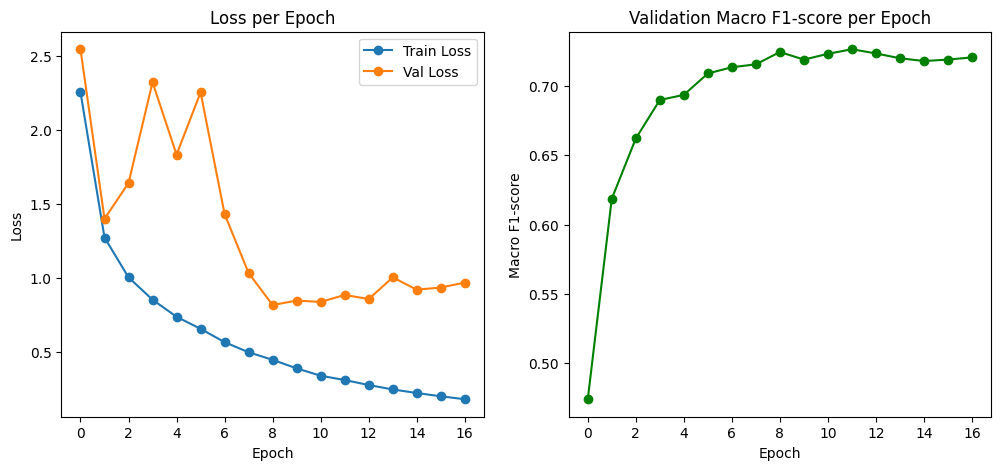

In [ ]:
# 11. Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='o', label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_f1_scores, marker='o', color='green')
plt.title("Validation Macro F1-score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1-score")
plt.savefig('F1_score.png', dpi=300)
plt.show()